In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from IPython.display import SVG
!python --version

#tensorflow.keras.models for NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
print(tf.__version__)

#sklearn for data preprocess
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
#matplotlib for ploting
import matplotlib.pyplot as plt
%matplotlib inline 
##able to display plots in colab notebook

#RDKit for Smile datatype preprocess
!pip install rdkit-pypi -qqq
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

#Allow this colab Notebook to Access files from personal google-drive (e.g.,"/content/drive/MyDrive/"=Home directory of personal google-drive)
import os
from google.colab import drive
drive.mount('/content/drive')
data_directory = os.path.join("/content/drive/MyDrive/")

Python 3.9.16
2.11.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#load data from xlsx file stored in personal google-drive
data= pd.read_excel("/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks/mGlu/sample01.xlsx")
df = data
print(df.shape)

(660, 24)


In [5]:
#create RDKit "MOL" data type from SMILES data type, and append "MOL" column in the end. 
df["MOL"] = df["SMILES"].apply(Chem.MolFromSmiles)
#display(df["MOL"][66])
#df.head()
print(df.shape)
#df["MOL"].head()

(660, 25)


In [6]:
#Input0=x0
# define function of "chemcepterize_mol()" to convert "MOL" type data into chemcepterized feature
##https://www.cheminformania.com/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/
def chemcepterize_mol(mol, embed=12.0, res=0.50):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2))
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
        idx = int(round((coords[i][0] + embed)/res))
        idy = int(round((coords[i][1]+ embed)/res))
        #Atomic number
        vect[ idx , idy, 1] = atom.GetAtomicNum()
        #Gasteiger Charges
        charge = atom.GetProp("_GasteigerCharge")
        vect[ idx , idy, 3] = charge
        #Hybridization
        hyptype = atom.GetHybridization().real
        vect[ idx , idy, 2] = hyptype
    return vect


In [7]:
#vectorize (iterate and arrange in order) whole molecules of "MOL" type into chemcepterized feature ""molimage"", and append ""molimage"" column in the end of df dataframe.
def vectorize(mol):
    return chemcepterize_mol(mol, embed=12)
df["molimage"] = df["MOL"].apply(vectorize)

In [8]:
print(df.shape)

(660, 26)


In [10]:
Imagesize = 96 #play around the meth, just make sure the Inputs[0]=660=total sample number.

In [13]:
#prepare inputs from df dataframe
Input0 = np.array(list(data["molimage"])).reshape(-1, Imagesize * Imagesize * 1).astype("float32")
print("Input0.shape="+str(Input0.shape))
Input1 = np.array(list(data["molimage"]))
print("Input1.shape="+str(Input1.shape))

Input0.shape=(660, 9216)
Input1.shape=(660, 48, 48, 4)


In [14]:
Inputs = Input0, Input1
print(len(Inputs))

2


In [15]:
#Inputs

In [16]:
#prepare outputs from df dataframe

def format_output(data):
    #####> options include ['mGluaffinity', 'xstand', 'xnorm']. Elsewhere, this will be referenced as 'numerical'
    y1 = data.pop("norm_mol_feature")
    #####>
    #y1 = data.pop("Normofinvlog")
    y1 = np.array(y1)
    y2 = data.pop('BinaryReceptorType')
    y2 = np.array(y2)
    y3 = data.pop('Original Label') #take original label from total data ahead
    y3 = np.array(y3)
    return y1, y2, y3

Outputs = format_output(data)
print(len(Outputs))

3


In [17]:
# prepare Inputs and Outputs for K-fold cross validation, and set/train/test model(randomized initialweights) inside the for-loop. 
import pandas
import os
import glob

appended_data = []

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)
ID_Inp = np.array(range(660)) # total sample number = 660
ID_Out = np.array(range(660))

for IDs_Train, IDs_Test in kfold.split(ID_Inp, ID_Out):
  Fold_Train_Input0, Fold_Train_Input1  = Inputs[0][IDs_Train],Inputs[1][IDs_Train]
  Fold_Train_OutPut0, Fold_Train_OutPut1 = Outputs[0][IDs_Train], Outputs[1][IDs_Train]

  Fold_Test_Input0, Fold_Test_Input1  = Inputs[0][IDs_Test],Inputs[1][IDs_Test]
  Fold_Test_OutPut0, Fold_Test_OutPut1 = Outputs[0][IDs_Test], Outputs[1][IDs_Test]

  #combined the inputs and outputs for train and test dataset
  Fold_Train_InputTotal = Fold_Train_Input0, Fold_Train_Input1
  Fold_Train_OutPutTotal = Fold_Train_OutPut0, Fold_Train_OutPut1

  Fold_Test_InputTotal = Fold_Test_Input0, Fold_Test_Input1
  Fold_Test_OutPutTotal = Outputs[0][IDs_Test], Outputs[1][IDs_Test]
  
  
  #====================================================================================
  #setup model
  from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
  from keras.layers.core import Dense, Dropout, Activation, Flatten
  from keras.optimizers import Adam

  input0 = Input(shape=9216)

  #Add dense layers to the input layer. These layers are commom to both predicted variables. 
  x = Dense(units=32,kernel_initializer='random_normal', activation='relu')(input0)
  x = Dense(units=32,kernel_initializer='random_normal', activation='relu')(x)
  x = Dense(units=64,kernel_initializer='random_normal', activation='relu')(x)
  x = Dense(units=64,kernel_initializer='random_normal', activation='relu')(x)
  x = Dense(units=128,kernel_initializer='random_normal', activation='relu')(x)
  x = Dense(units=128,kernel_initializer='random_normal', activation='relu')(x)

  #input1 (y2) pass a toy ResNet model (https://keras.io/guides/functional_api/)
  input1 = Input(shape=(48, 48, 4), name="img")
  x1 = Conv2D(32, 3, activation="relu",kernel_initializer='random_normal')(input1)
  x1 = Conv2D(64, 3, activation="relu",kernel_initializer='random_normal')(x1)
  block_1_output = MaxPooling2D(3)(x1)

  x1 = Conv2D(64, 3, activation="relu", padding="same",kernel_initializer='random_normal')(block_1_output)
  x1 = Conv2D(64, 3, activation="relu", padding="same",kernel_initializer='random_normal')(x1)
  block_2_output = layers.add([x1, block_1_output])

  x1 = Conv2D(64, 3, activation="relu", padding="same",kernel_initializer='random_normal')(block_2_output)
  x1 = Conv2D(64, 3, activation="relu", padding="same",kernel_initializer='random_normal')(x1)
  block_3_output = layers.add([x1, block_2_output])

  x1 = Conv2D(64, 3, activation="relu",kernel_initializer='random_normal')(block_3_output)
  x1 = layers.GlobalAveragePooling2D()(x1)
  x1 = Dense(256, activation="relu",kernel_initializer='random_normal')(x1)
  x1 = Dropout(0.5)(x1)

  #x1 = Inception0(input1)
  #x1 = Inception(x1)
  #od=int(x1.shape[1])
  #x1 = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x1)
  #x1 = Flatten()(x1)
  #x1 = Dense(100, activation='relu')(x1)

  merge = layers.concatenate([x, x1])
  merge = Dense(units=2000,kernel_initializer='random_normal', activation='relu')(merge)
  merge = Dropout(0.1)(merge)
  merge = Dense(units=500,kernel_initializer='random_normal', activation='relu')(merge)

  n2 = Dense(units=500,kernel_initializer='random_normal', activation='relu')(merge)
  n2 = Dense(units=50,kernel_initializer='random_normal', activation='relu')(n2)
  n2 = Dropout(0.3)(n2)
  n3 = Dense(units=10,kernel_initializer='random_normal', activation='relu')(n2)
  y1_output = Dense(units=1,kernel_initializer='random_normal', activation='sigmoid', name='norm_mol_feature_layrer')(n3)

  m2 = Dense(units=500,kernel_initializer='random_normal', activation='relu')(merge)
  m2 = Dense(units=50,kernel_initializer='random_normal', activation='relu')(m2)
  m2 = Dropout(0.3)(m2)
  m2 = Dense(units=10, kernel_initializer='random_normal',activation='relu')(m2)
  y2_output = Dense(units=1,kernel_initializer='random_normal', activation='relu', name='BinaryReceptorType_layer')(m2)
  #add branch1: Output0 layer(y1) as BinaryReceptorType_layer using Sigmoid activation for binary classification task. 
  #BinaryReceptorType_layer = Dense(units = 1,kernel_initializer='random_normal', activation='sigmoid', name='BinaryReceptorType_layer')(x)

  #add branch2: Output1 layer(y2) as norm_mol_feature_layrer using relu activation for numerical prediction task.
  #norm_mol_feature_layrer01 =Dense(units=64,kernel_initializer='random_normal', name='norm_mol_feature_layrer01', activation='relu')(x)
  #norm_mol_feature_layrer = Dense(units=1,kernel_initializer='random_normal', name='norm_mol_feature_layrer')(norm_mol_feature_layrer01)

  #assign one input and two outputs into "model" by Model() function. 
  model = Model(inputs=[input0, input1], outputs=[y1_output, y2_output])

  #set optimizers 
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
  #optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


  #To compile the model we use two dictionaries, to indicate the loss functions and metrics  
  model.compile(optimizer=optimizer, 
                loss = {'BinaryReceptorType_layer' : 'binary_crossentropy', 
                          'norm_mol_feature_layrer' : 'mse'
                      },
                metrics = {'BinaryReceptorType_layer' : 'accuracy', 
                            'norm_mol_feature_layrer': tf.keras.metrics.RootMeanSquaredError()
                        }
              ) 
  #====================================================================================
  #trian and test the model for 5 repeats (K-fold cross validation) with randomized initial weights.
  history = model.fit(Fold_Train_InputTotal, Fold_Train_OutPutTotal, 
                    epochs =100,batch_size=50, shuffle=True, validation_data=(Fold_Test_InputTotal, Fold_Test_OutPutTotal))
  loss,  norm_loss, rec_type_loss, norm_rmse, rec_type_accuracy = model.evaluate(x=Fold_Test_InputTotal, y=Fold_Test_OutPutTotal)

  print()
  print("Test Results from K-fold cross validation")
  print(f'loss: {loss}')
  print(f'norm_loss: {norm_loss}')
  print(f'rec_type_loss: {rec_type_loss}')
  print(f'norm_rmse: {norm_rmse}')
  print(f'rec_accuracy: {rec_type_accuracy}')
  print("\n")
  print("\n")
  print("\n")
  print("\n")
  print("\n")

Epoch 1/100
11/11 [==============================] - 10s 94ms/step - loss: 9.0431 - norm_mol_feature_layrer_loss: 0.0688 - BinaryReceptorType_layer_loss: 8.9744 - norm_mol_feature_layrer_root_mean_squared_error: 0.2622 - BinaryReceptorType_layer_accuracy: 0.4148 - val_loss: 0.0090 - val_norm_mol_feature_layrer_loss: 0.0085 - val_BinaryReceptorType_layer_loss: 4.9746e-04 - val_norm_mol_feature_layrer_root_mean_squared_error: 0.0921 - val_BinaryReceptorType_layer_accuracy: 1.0000
Epoch 2/100
11/11 [==============================] - 0s 20ms/step - loss: 4.0102 - norm_mol_feature_layrer_loss: 0.0685 - BinaryReceptorType_layer_loss: 3.9417 - norm_mol_feature_layrer_root_mean_squared_error: 0.2618 - BinaryReceptorType_layer_accuracy: 0.4148 - val_loss: 0.0119 - val_norm_mol_feature_layrer_loss: 0.0086 - val_BinaryReceptorType_layer_loss: 0.0034 - val_norm_mol_feature_layrer_root_mean_squared_error: 0.0925 - val_BinaryReceptorType_layer_accuracy: 1.0000
Epoch 3/100
11/11 [====================

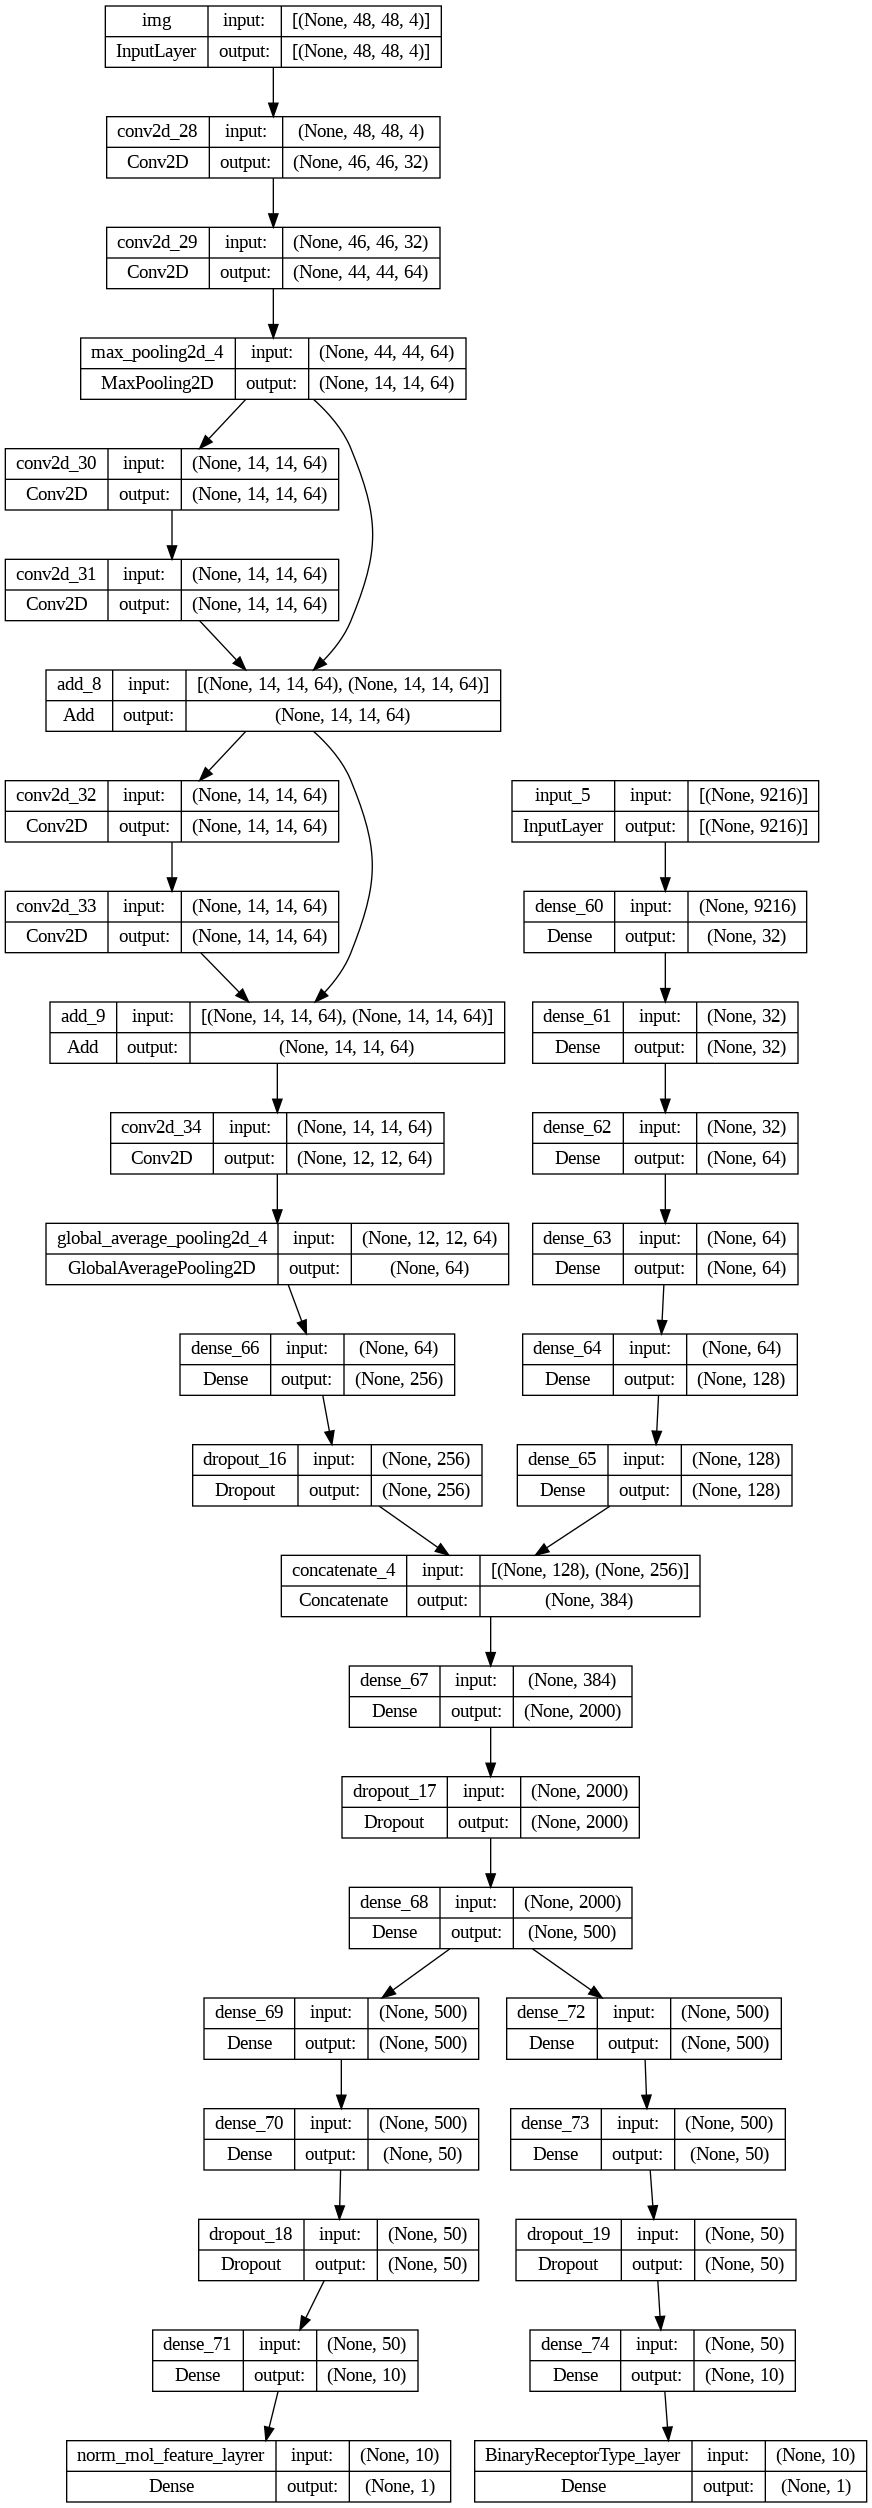

In [18]:
tf.keras.utils.plot_model(model, "multi.png", show_shapes=True)

In [19]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 48, 48, 4)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 46, 46, 32)   1184        ['img[0][0]']                    
                                                                                                  
 conv2d_29 (Conv2D)             (None, 44, 44, 64)   18496       ['conv2d_28[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 14, 14, 64)  0           ['conv2d_29[0][0]']              
                                                                                            